# Na analysis (run 3614)

# Notebook configuration

In [1]:
outputfolder   = "plots/"
save_plots     = False

In [2]:
from __future__ import print_function, division

import os
import functools
import textwrap
import time
import glob
print("Running on ", time.asctime())

import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import scipy             as scp
import scipy.interpolate

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf

pi = np.pi

coref = fitf

Running on  Fri May  5 18:07:18 2017


#### General plotting options

In [3]:
%matplotlib inline

plt.rcParams["figure.figsize"]          = 10, 8
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "-r"
XR1Opt  = "-k"
XR2Opt  = "-c"

if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Useful functions

In [4]:
def labels(xlabel, ylabel):
    """
    Set x and y labels.
    """
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def hist(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist(*args, **kwargs)


def doublehist(data1, data2, lbls, *args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    h1 = plt.hist(data1, *args, label=lbls[0], alpha=0.5, normed=True, **kwargs)
    h2 = plt.hist(data2, *args, label=lbls[1], alpha=0.5, normed=True, **kwargs)
    return h1, h2, plt.legend()

    
def hist2d(*args, **kwargs):
    """
    Create a figure and then the histogram
    """
    plt.figure()
    return plt.hist2d(*args, **kwargs)

    
def pdf(data, *args, **kwargs):
    """
    Create a normalized histogram with appropiate range.
    """
    data = np.array(data)
    h = hist(data, *args, **kwargs, weights=np.ones_like(data)/len(data))
    plt.yscale("log")
    plt.ylim(1e-4, 1.)
    return h
    
def scatter(*args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    return plt.scatter(*args, **kwargs)


def profile_and_scatter(x, y, z, nbin, xrange, yrange, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, xrange, yrange)
    x_ = np.repeat(x, y.size)
    y_ = np.tile  (y, x.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.hist2d(x_, y_, nbin, (xrange, yrange), weights=z_), plt.colorbar()


def doublescatter(x1, y1, x2, y2, lbls, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    sc1 = plt.scatter(x1, y1, *args, label=lbls[0], **kwargs)
    sc2 = plt.scatter(x2, y2, *args, label=lbls[1], **kwargs)
    return sc1, sc2, plt.legend()


def covariance(x, y):
    cov = np.cov(x, y)
    l, v = np.linalg.eig(cov)
    lx, ly = l**0.5
    vx, vy = v.T
    x0, y0 = np.mean(x), np.mean(y)
    x1     = lx * vx[0]
    y1     = lx * vx[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*ly, head_length=0.1*lx, fc='r', ec='r')
    x1     = ly * vy[0]
    y1     = ly * vy[1]
    plt.arrow(x0, y0, x1, y1, head_width=0.1*lx, head_length=0.1*ly, fc='r', ec='r')
    return l, v

def reso(values, ene=29.6):
    _, mu, sigma = values
    r = 235. * sigma/mu
    return r, r * (ene/2458)**0.5

def gausstext(values, ene=29.6):
    return textwrap.dedent("""
        $\mu$ = {:.1f}
        $\sigma$ = {:.2f}
        R = {:.3}%
        Rbb = {:.3}%""".format(*values[1:], *reso(values, ene)))

def save_to_folder(save_plots, outputfolder, name):
    """
    Set title and save plot in folder.
    """
    plt.title(name)
    if save_plots:
        plt.savefig("{}/{}.png".format(outputfolder, name), dpi=100)

def get_xycorr(xs, ys, es, eref=None):
    if eref is None:
        eref = es[es.shape[0]//2, es.shape[1]//2]
    xs   = xs.reshape(xs.size, 1)
    ys   = ys.reshape(ys.size, 1)
    print(eref)
    def xycorr(x, y):
        x_closest = np.apply_along_axis(np.argmin, 0, abs(x-xs))
        y_closest = np.apply_along_axis(np.argmin, 0, abs(y-ys))
        e = es[x_closest, y_closest]
        e[e<1e3] = eref
        return eref/ e
    return xycorr

def get_tcorr(ts, es, t0 = 0, eref=None):
    if eref is None:
        eref = np.max(es)
    ts   = ts.reshape(ts.size, 1) + t0
    print(eref)
    def tcorr(t):
        t_closest = np.apply_along_axis(np.argmin, 0, abs(t-ts))
        e = es[t_closest]
        return eref/ e
    return tcorr


save = functools.partial(save_to_folder, save_plots, outputfolder)

### Input data

In [57]:
inputfilenames = "/Users/Gonzalo/github/NEXTdata/Na22/dst_*.root.h5"
ifiles = glob.glob(os.path.expandvars(inputfilenames))
ifiles.pop(1)
iruns  = [ifile.split("_")[1].split(".")[0] for ifile in ifiles]
idates = ["08/04", "19/04", "19/04", "20/04", "21/04", "22/04",
          "23/04", "24/04", "25/04", "25/04", "26/04", "26/04",
          "27/04", "27/04", "27/04", "28/04", "28/04", "29/04", "29/04"]
for ifile, idate in zip(ifiles, idates):
    with tb.open_file(ifile) as h5f:
        print("ifile:\t", ifile, h5f.root.DST.Events.nrows, "\t", idate)

ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3614.root.h5 156902 	 08/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3723.root.h5 1076 	 19/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3732.root.h5 3464 	 19/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3740.root.h5 13899 	 20/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3752.root.h5 16682 	 21/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3755.root.h5 14870 	 22/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3757.root.h5 17051 	 23/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3761.root.h5 16570 	 24/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3763.root.h5 6492 	 25/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3768.root.h5 9593 	 25/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3770.root.h5 6688 	 26/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3773.root.h5 9117 	 26/04
ifile:	 /Users/Gonzalo/github/NEXTdata/Na22/dst_3779.root.h5 3934 	 27/04
ifile:	 /Users/Gonzalo/github/N

# Read data

In [6]:
dsts = [dstf.load_dst(ifile, "DST", "Events") for ifile in ifiles]

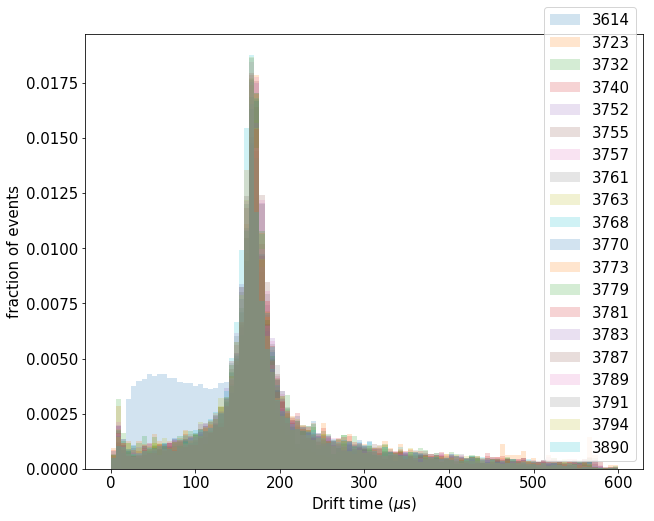

In [7]:
for run, dst in zip(iruns, dsts):
    plt.hist(dst.Z.values, np.linspace(0, 600, 100), label=run, alpha=0.2, normed=True)

plt.legend()
labels("Drift time ($\mu$s)", "fraction of events")

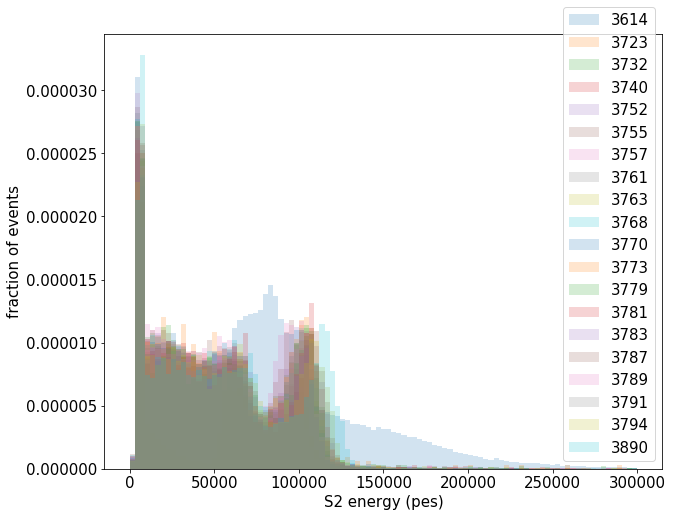

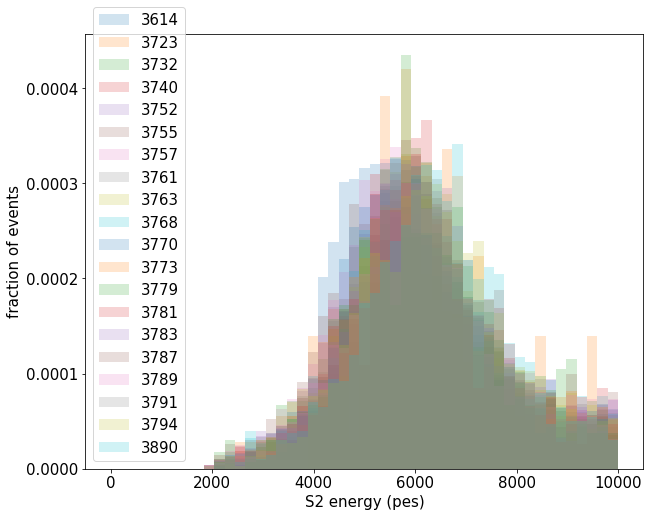

In [8]:
for run, dst in zip(iruns, dsts):
    plt.hist(dst.S2e.values, np.linspace(0, 3e5, 100), label=run, alpha=0.2, normed=True)

plt.legend()
labels("S2 energy (pes)", "fraction of events")

plt.figure()
for run, dst in zip(iruns, dsts):
    plt.hist(dst.S2e.values, np.linspace(0, 1e4, 50), label=run, alpha=0.2, normed=True)

plt.legend()
labels("S2 energy (pes)", "fraction of events")

# Compute lifetime from XR

In [58]:
XRs  = [dst[coref.in_range(dst.Z  ,   0, 160) &
            coref.in_range(dst.R  ,   0, 100) &
            coref.in_range(dst.S2e, 4e3, 1e4)] for dst in dsts]

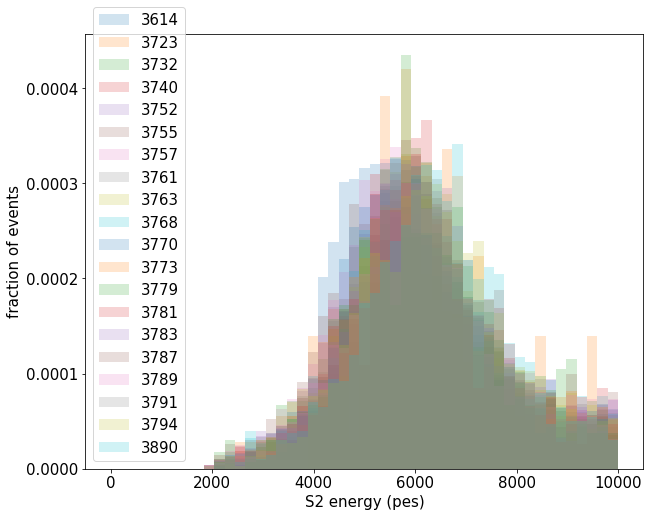

In [59]:
for run, dst in zip(iruns, dsts):
    plt.hist(dst.S2e.values, np.linspace(0, 1e4, 50), label=run, alpha=0.2, normed=True)

plt.legend()
labels("S2 energy (pes)", "fraction of events")

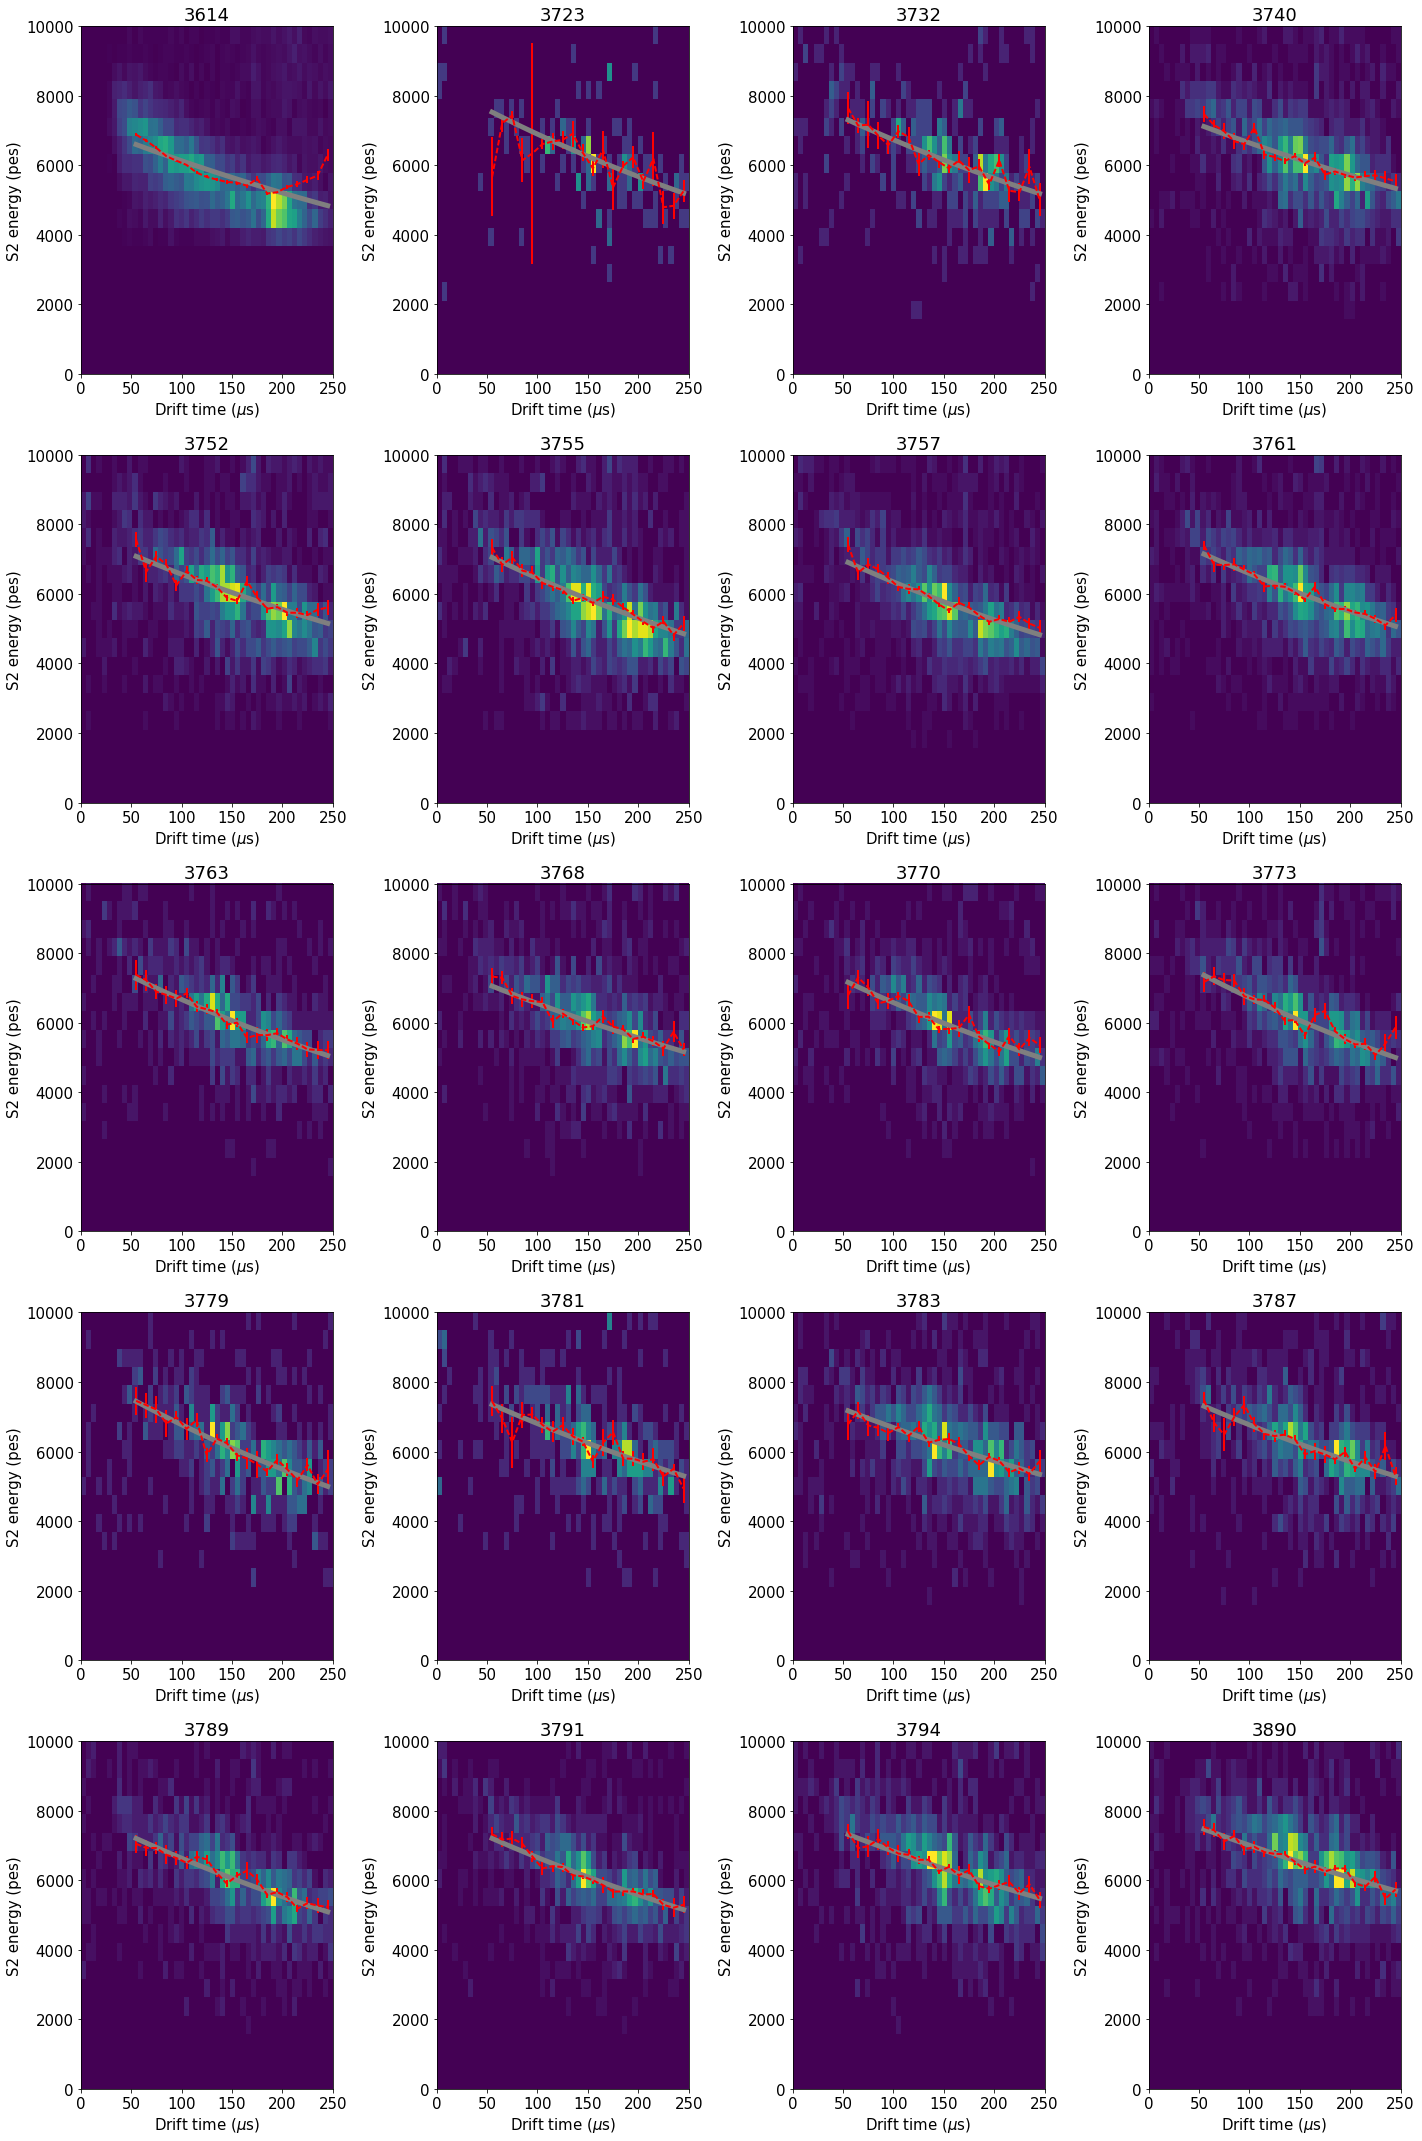

In [69]:
i = 1

zcorrs = []
lts    = []
slts   = []
plt.figure(figsize=(20,30))
for run, dst in zip(iruns, dsts):
    plt.subplot(5, 4, i); i+= 1
    plt.hist2d(dst.Z.values, dst.S2e.values, (np.linspace(0, 250, 50),
                                              np.linspace(0, 1e4, 20)))
    x, y, ye = fitf.profileX(dst.Z.values, dst.S2e.values, 20, (50, 250), (0, 1e4))
    ye[ye==0] = 0.5 * y[ye==0]
    f = fitf.fit(fitf.expo, x, y, (1e4, -3e2), fit_range=(50, 250), sigma=ye)
    zcorrs.append(lambda z: np.exp(z/f.values[1]))
    lts   .append(-f.values[1])
    slts  .append( f.errors[1])

    plt.errorbar(x, y, ye, fmt="r--", lw=2)
    plt.plot    (x, f.fn(x), "C7-", lw=5)

    plt.title(run)
    labels("Drift time ($\mu$s)", "S2 energy (pes)")
plt.tight_layout()

In [70]:
aruns = [3645, 3715, 3724, 3733, 3741, 3753, 3756, 3758, 3762, 3767, 3769, 3772, 3774, 3782, 3784, 3788, 3790, 3793, 3795, 3822, 3824, 3826, 3829, 3855, 3883, 3888]
alts  = [474.4109931194628, 504.1525191957807, 519.3091783787069, 518.0281141306968, 532.9715991079876, 415.5119531678706, 397.454274869814, 428.5179457007686, 515.5085611752636, 422.80059055577334, 518.0208332090502, 419.97646149139285, 429.75838777926833, 521.8329715688114, 469.2174542922276, 463.826604058616, 461.0661944698737, 500.6616657051581, 540.3974621122891, 549.0781009102475, 544.5759390428727, 543.2689035001792, 548.4509769880807, 577.4450382051101, 533.543925757036, 580.9708922447577]
aslts = [0.45610521129754389, 0.39496148002734938, 7.1924391956263989, 6.3141707641315312, 4.5069070673219533, 0.54717654845191099, 1.6326697526988669, 0.58043603501794649, 2.1244323267837881, 0.28654390913506583, 3.822902769037376, 3.650949171398798, 1.5991794319982626, 4.2184333670711194, 0.2673803059344585, 15.249539113903822, 11.22508358475883, 5.9907961163047405, 1.9609900515946075, 10.630602475189789, 15.572425132253926, 10.651666662207665, 2.6543080579975458, 22.898075395102662, 0.46222534245673397, 17.685030116954312]


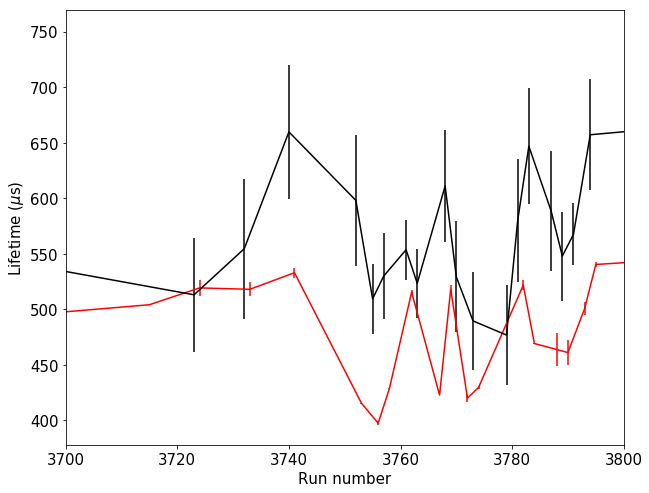

In [73]:
plt.errorbar(aruns, alts, aslts, fmt="r-")
plt.errorbar(list(map(int, iruns)),  lts,  slts, fmt="k-")
plt.xlim(3700, 3800)
labels("Run number", "Lifetime ($\mu$s)")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


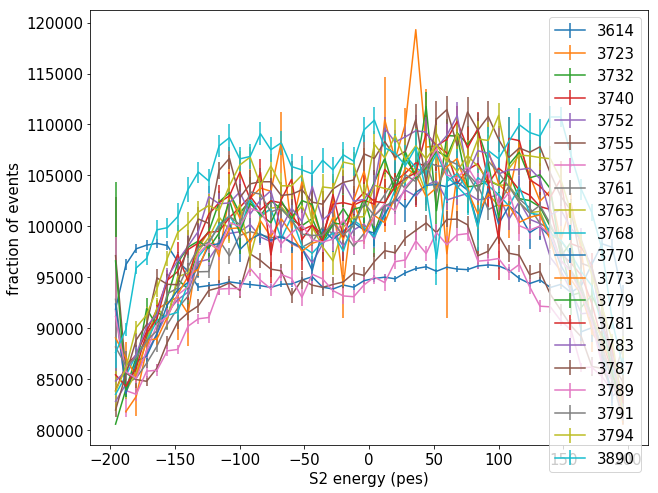

In [56]:
for run, dst in zip(iruns, dsts):
    plt.errorbar(*fitf.profileX(dst.X.values, dst.S2e.values, 50, (-200, 200), (80e3, 120e3)), label=run)

plt.legend()
labels("S2 energy (pes)", "fraction of events")

In [50]:
print(list(map(int,"""3645,
 3715,
 3724,
 3733,
 3741,
 3753,
 3756,
 3758,
 3762,
 3767,
 3769,
 3772,
 3774,
 3782,
 3784,
 3788,
 3790,
 3793,
 3795,
 3822,
 3824,
 3826,
 3829,
 3855,
 3883,
 3888""".split(",\n"))))

[3645, 3715, 3724, 3733, 3741, 3753, 3756, 3758, 3762, 3767, 3769, 3772, 3774, 3782, 3784, 3788, 3790, 3793, 3795, 3822, 3824, 3826, 3829, 3855, 3883, 3888]


In [53]:
print(list(map(float,"""474.41099311946277,
 504.15251919578071,
 519.30917837870686,
 518.02811413069685,
 532.97159910798757,
 415.51195316787062,
 397.45427486981401,
 428.51794570076862,
 515.50856117526359,
 422.80059055577334,
 518.02083320905024,
 419.97646149139285,
 429.75838777926833,
 521.83297156881144,
 469.21745429222761,
 463.826604058616,
 461.06619446987372,
 500.6616657051581,
 540.39746211228908,
 549.07810091024749,
 544.57593904287273,
 543.26890350017925,
 548.4509769880807,
 577.44503820511011,
 533.54392575703605,
 580.97089224475769""".split(",\n"))))

[474.4109931194628, 504.1525191957807, 519.3091783787069, 518.0281141306968, 532.9715991079876, 415.5119531678706, 397.454274869814, 428.5179457007686, 515.5085611752636, 422.80059055577334, 518.0208332090502, 419.97646149139285, 429.75838777926833, 521.8329715688114, 469.2174542922276, 463.826604058616, 461.0661944698737, 500.6616657051581, 540.3974621122891, 549.0781009102475, 544.5759390428727, 543.2689035001792, 548.4509769880807, 577.4450382051101, 533.543925757036, 580.9708922447577]


In [45]:
aruns  = [3769, 3767, 3762, 3758, 3756, 3753, 3741, 3733, 3724, 3715, 3645]
alts   = [526.0, 435.0, 516.0, 446.0, 396.0, 416.0, 533.0, 518.0, 520.0, 504.0, 474.0]
aslts  = [5.3, 6.8, 2.2, 5.0, 5.3, 1.3, 4.4, 6.1, 7.0, 1.0, 0.5]
adates = ['26/4', '25/4', '25/4', '24/4', '23/4', '22/4', '21/4', '20/4', '19/4', '19/4', '15/4']

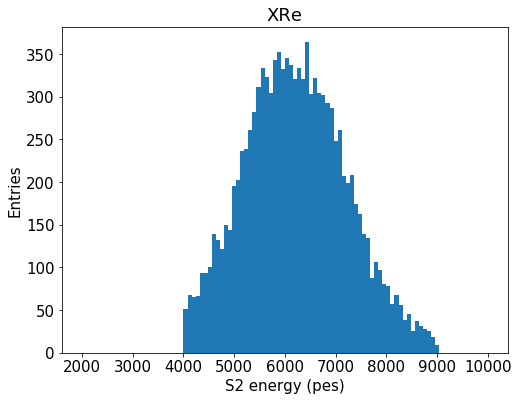

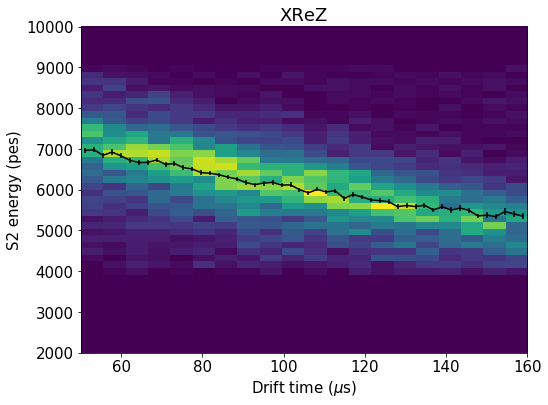

In [11]:
zrange  = zrange_
XRrange = XRrange_

hist(XR.S2e, 100, XRrange)
labels("S2 energy (pes)", "Entries")
save("XRe")

hist2d(XR.Z, XR.S2e, (20, 50), range=(zrange, XRrange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

x, y, ye = fitf.profileX(XR.Z, XR.S2e, 50, zrange)
plt.errorbar(x, y, ye, fmt="-k")
save("XReZ")

[ 8680.37754068  -327.96571706] 0.615803822023


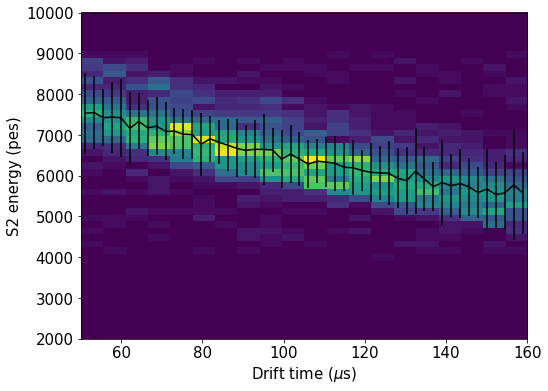

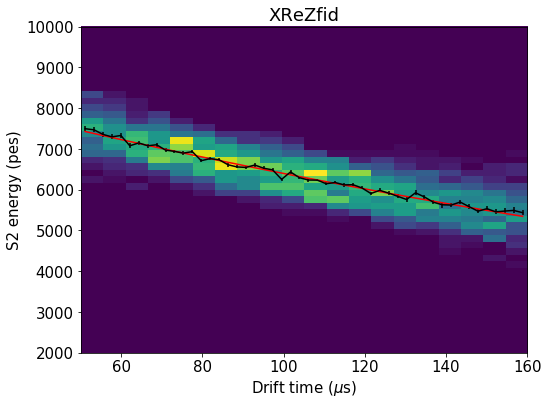

In [12]:
zrange = zrange_
Erange = XRrange_

XRfid = XR[coref.in_range(XR.R, 0, 100)]

hist2d(XRfid.Z, XRfid.S2e, (20, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

x, y, ye = fitf.profileX(XRfid.Z, XRfid.S2e, 50, zrange)
plt.errorbar(x, y, ye*10, fmt="-k")

xr_emin = scp.interpolate.interp1d(x, y - ye*15, fill_value="extrapolate")
xr_emax = scp.interpolate.interp1d(x, y + ye*10, fill_value="extrapolate")

XRfid = XRfid[coref.in_range(XRfid.S2e, xr_emin(XRfid.Z), xr_emax(XRfid.Z))]
hist2d(XRfid.Z, XRfid.S2e, (20, 50), range=(zrange, Erange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")

x, y, ye = fitf.profileX(XRfid.Z, XRfid.S2e, 50, zrange)
plt.errorbar(x, y, ye, fmt="-k")

f = fitf.fit(fitf.expo, x, y, (8e3, -4e2), sigma=ye)
plt.plot(x, f.fn(x), fitOpt)
save("XReZfid")
print(f.values, f.chi2)

zfun  = f.fn
znorm = zfun(zrange[0])
zcorr = lambda z: znorm/zfun(z)

# S2 energy corrected by attachment

[  4.75053709e+05   7.53605197e+03   4.15594289e+02   5.45144707e+00] 0.962714691869 (12.959658231979445, 1.4221600178579097)
[  8.81158121e+05   7.25538097e+03   4.88293313e+02   9.07522734e+02
  -9.09142657e-02] 5.04866866574 (15.815699969499613, 1.7355747928256466)


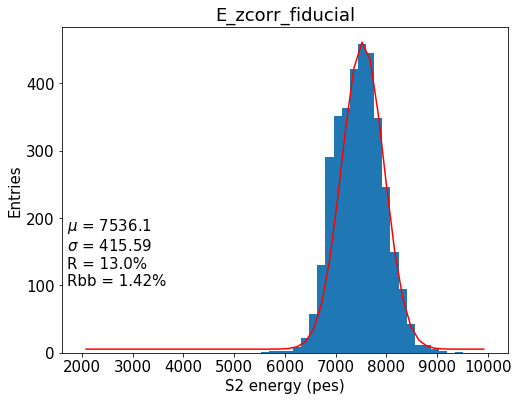

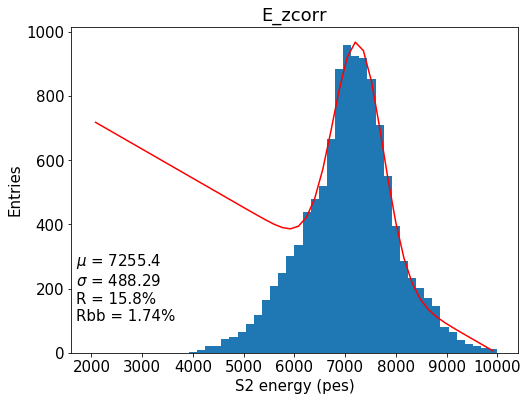

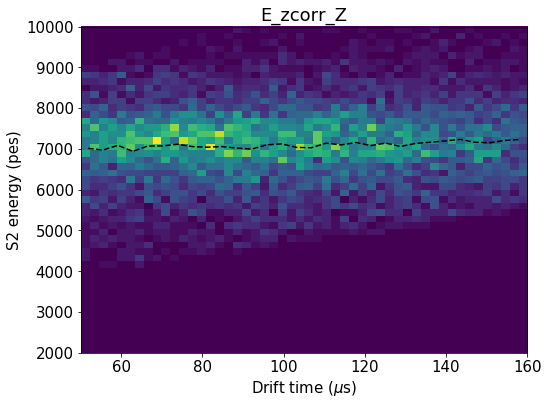

In [13]:
zrange = zrange_
Erange = XRrange_

y, x, _ = \
hist(XRfid.S2e * zcorr(XRfid.Z), 50, range=Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
seed = 1e6, 7e3, 6e2, 1
f = fitf.fit(fun, x, y, seed, fit_range=(7300, 9000))
plt.plot(x, f.fn(x), "r-")
print(f.values, f.chi2, reso(f.values[:3], 29.6))
plt.ylim(0)
plt.text(plt.xlim()[0] + 100, plt.ylim()[0] + 100, gausstext(f.values[:3], 29.6))

labels("S2 energy (pes)", "Entries")
save("E_zcorr_fiducial")


y, x, _ = \
hist(XR.S2e * zcorr(XR.Z), 50, range=Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
seed = 1e6, 7e3, 6e2, 2e3, -0.1
f = fitf.fit(fun, x, y, seed, fit_range=(6500, 10000))
plt.plot(x, f.fn(x), "r-")
print(f.values, f.chi2, reso(f.values[:3], 29.6))
plt.ylim(0)
plt.text(plt.xlim()[0] + 100, plt.ylim()[0] + 100, gausstext(f.values[:3], 29.6))

labels("S2 energy (pes)", "Entries")
save("E_zcorr")

hist2d(XR.Z, XR.S2e * zcorr(XR.Z), (50, 50), range=(zrange, Erange))
x, y, _ = fitf.profileX(XR.Z, XR.S2e* zcorr(XR.Z), 30, xrange=zrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")
save("E_zcorr_Z")


# Energy vs position

7598.91219545


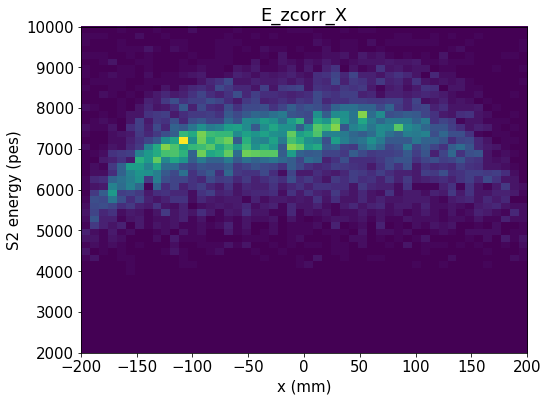

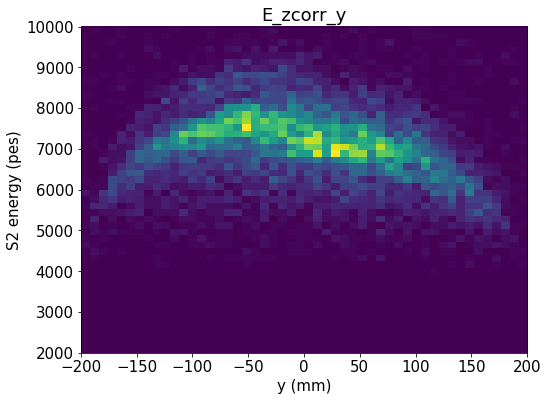

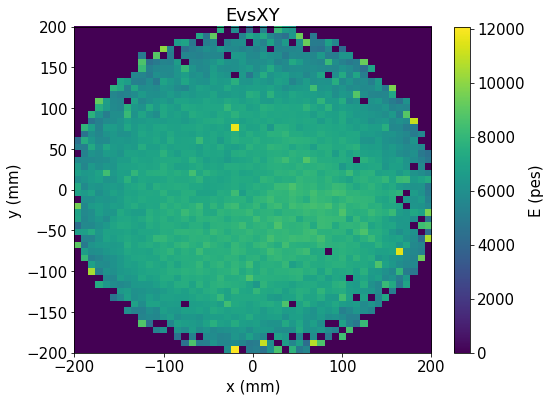

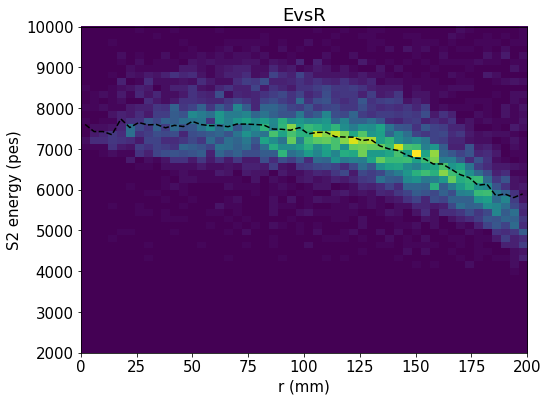

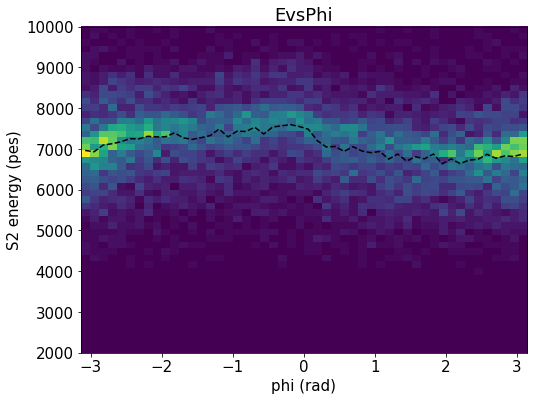

In [14]:
xrange = -200, 200
yrange = -200, 200
rrange =    0, 200
prange = - pi,  pi
Erange =  XRrange_

E = XR.S2e * zcorr(XR.Z)

hist2d(XR.X, E, 50, range=(xrange, Erange))
labels("x (mm)", "S2 energy (pes)")
save("E_zcorr_X")

hist2d(XR.Y, E, 50, range=(yrange, Erange))
labels("y (mm)", "S2 energy (pes)")
save("E_zcorr_y")

pf, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange, yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

hist2d(XR.R, E, (50, 50), (rrange, Erange))
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), (prange, Erange))
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")

xycorr = get_xycorr(*pf[:-1])


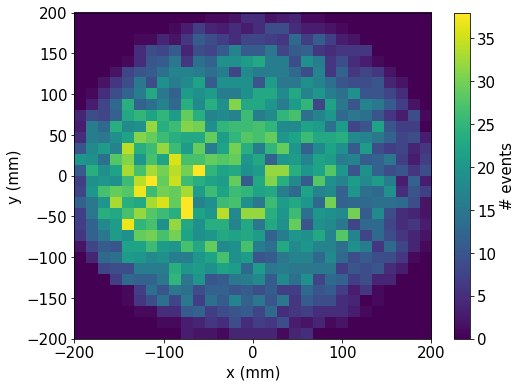

In [44]:
hist2d(XR.X.values, XR.Y.values, 30, ((-200, 200), (-200, 200)))
labels("x (mm)", "y (mm)")
plt.colorbar().set_label("# events")

# Correction by attachment and position

[  6.50888145e+05   7.44929398e+03   3.04616415e+02   1.36118252e+05
   8.32368226e+03   2.75021211e+02   1.67768935e+01] 3.21788930642


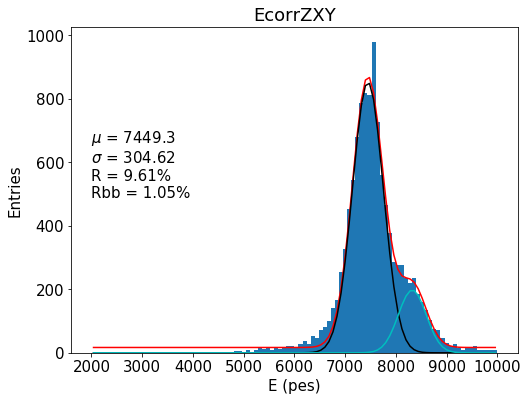

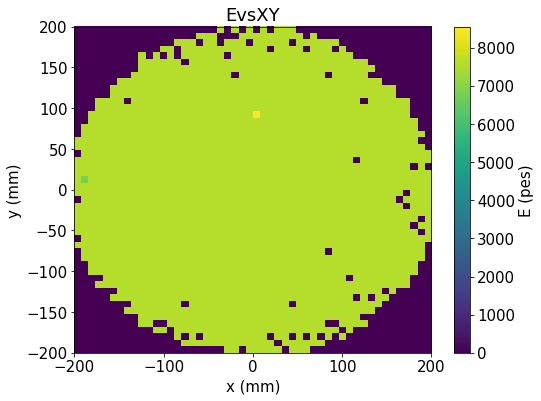

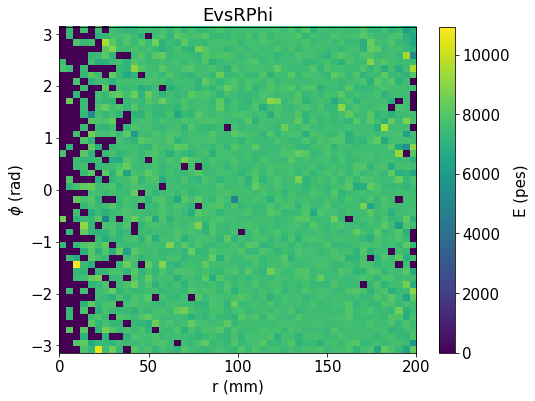

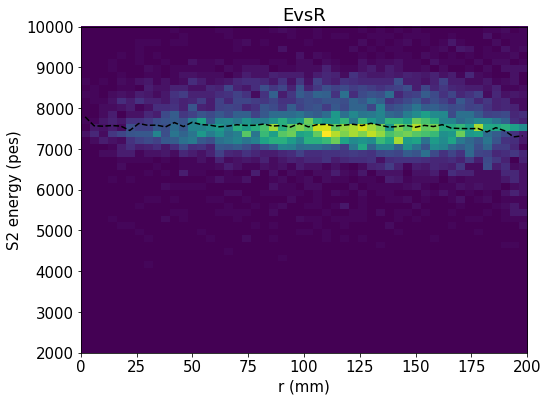

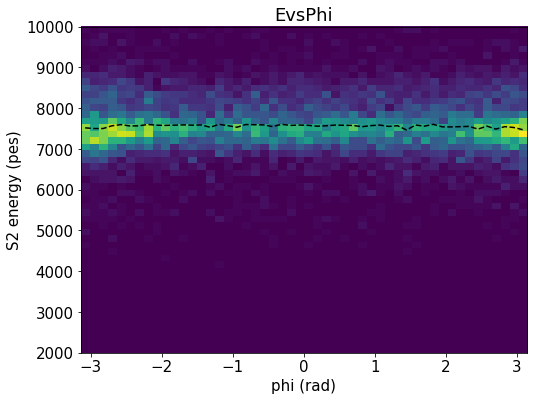

In [15]:
xrange = -200, 200
yrange = -200, 200
rrange =    0, 200
prange = - pi,  pi
Erange =  XRrange_

E  = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)

y, x, _ = hist(E, 100, Erange)
x    = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + args[-1]
seed = 1e3, 7500, 100, 1e3, 9000, 200,  1
low  =  10, 7000,  50,  10, 8000, 100,  0
upp  = 5e6, 8200, 800, 5e5, 9200, 800, 50
f    = fitf.fit(fun, x, y, seed, fit_range=(7000, 10000), bounds=(low, upp))
print(f.values, f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:6]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))
labels("E (pes)", "Entries")
save("EcorrZXY")

_, _, cb = profile_and_scatter(XR.X, XR.Y, E, (50, 50), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("EvsXY")

_, _, cb = profile_and_scatter(XR.R, XR.Phi, E, (50, 50), xrange=rrange, yrange=prange)
cb.set_label("E (pes)")
labels("r (mm)", "$\phi$ (rad)")
save("EvsRPhi")

hist2d(XR.R, E, (50, 50), range=(rrange, Erange))
x, y, _ = fitf.profileX(XR.R, E, 50, xrange=rrange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")
save("EvsR")

hist2d(XR.Phi, E, (50, 50), range=(prange, Erange))
x, y, _ = fitf.profileX(XR.Phi, E, 50, xrange=prange, yrange=Erange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 energy (pes)")
save("EvsPhi")


# Energy vs time

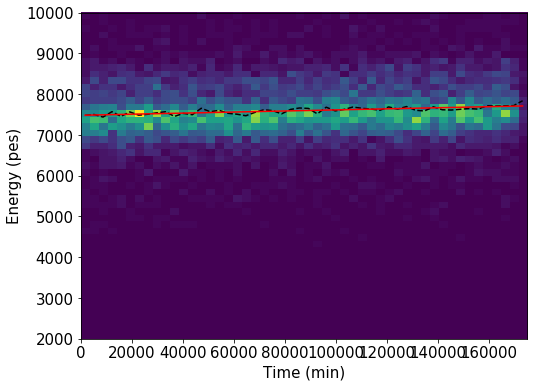

In [16]:
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values)
T = (XR.time - np.min(XR.time))

Erange = XRrange
Trange = 0, 175000

hist2d(T, E, (50, 50), range=(Trange, Erange))

x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")

f = fitf.fit(fitf.polynom, x, y, (8e3, 1))
plt.plot(x, f.fn(x), fitOpt)


tfun  = f.fn
tmax  = tfun(Trange[1])
tcorr = lambda t: tmax/tfun(t)

[  1.35354431e+06   7.56220200e+03   3.26105110e+02   2.35684736e+05
   8.48740436e+03   2.47343278e+02   3.53724549e+01] 2.92734009342


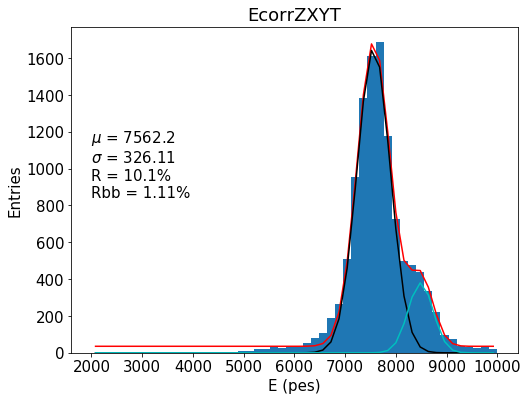

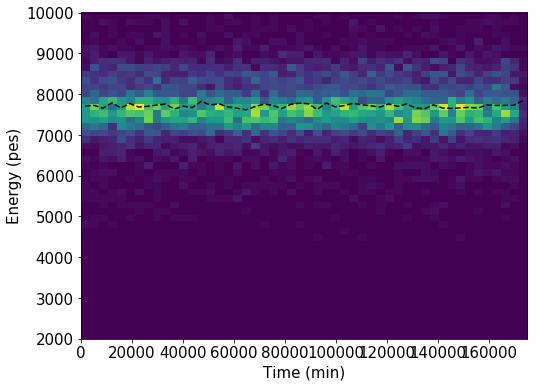

In [17]:
T = (XR.time - np.min(XR.time))
E = XR.S2e * zcorr(XR.Z) * xycorr(XR.X.values, XR.Y.values) * tcorr(T)

Trange = 0, 175000
Erange = XRrange

y, x, _ = hist(E, 50, Erange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:6]) + args[-1]
seed = 1e3, 7500, 100, 1e3, 9000, 200,  1
low  =  10, 7000,  50,  10, 8000, 100,  0
upp  = 5e6, 8200, 800, 5e5, 9200, 800, 50
f    = fitf.fit(fun, x, y, seed, fit_range=(7000, 10000), bounds=(low, upp))
print(f.values, f.chi2)

plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:6]), XR2Opt)
plt.text(Erange[0], max(y)/2, gausstext(f.values[:3]))
labels("E (pes)", "Entries")
save("EcorrZXYT")

hist2d(T, E, (50, 50), range=(Trange, Erange))
x, y, _ = fitf.profileX(T, E, 50, Trange)
plt.plot(x, y, profOpt)

labels("Time (min)", "Energy (pes)")


[  2.13929626e+07   1.26507500e+05   6.73225359e+03   5.62441568e+03
  -7.07261737e+04] 2.08548363029


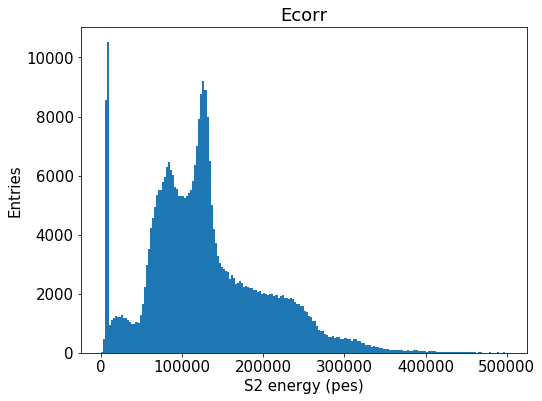

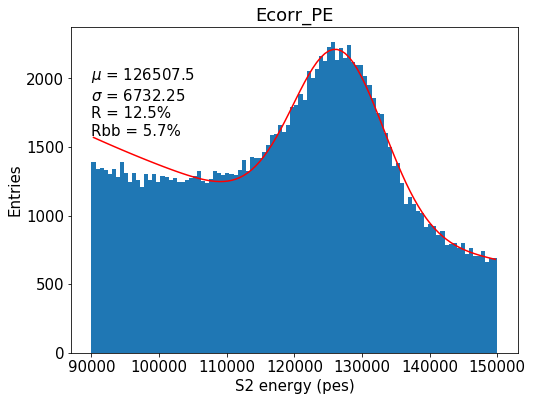

In [18]:
Erange  =   0,  5e5
PErange = 9e4, 15e4
E       = full.S2e * zcorr(full.Z) * xycorr(full.X.values, full.Y.values)

hist(E, 200, Erange)
labels("S2 energy (pes)", "Entries")
save("Ecorr")

y, x, _ = \
hist(E, 100, PErange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.expo(x, *args[3:5])
seed = 1e7, 125e3, 1e3, 1e5, -1e4
f    = fitf.fit(fun, x, y, seed, fit_range=(100e3, 150e3))
print(f.values, f.chi2)
plt.plot(x, f.fn(x), fitOpt)
plt.text(PErange[0], plt.ylim()[1]*2/3, gausstext(f.values[:3], 511))

labels("S2 energy (pes)", "Entries")
save("Ecorr_PE")

In [19]:
PE = full
PE = PE[coref.in_range(PE.S1e,  100,   150)]
PE = PE[coref.in_range(PE.S2e, 50e3, 110e3)]
PE = PE[coref.in_range(PE.Z  ,  160,   185)]
PE = PE[coref.in_range(PE.Y  ,  -20,    20)]
#PE = PE[coref.in_range(PE.X  , -100,   -10)]
PE = PE[PE.nS2==1]

#PE = PE[coref.in_range(PE.S2e * zcorr(PE.Z) * xycorr(PE.X.values, PE.Y.values), 110e3, 150e3)]

len(PE)

29499

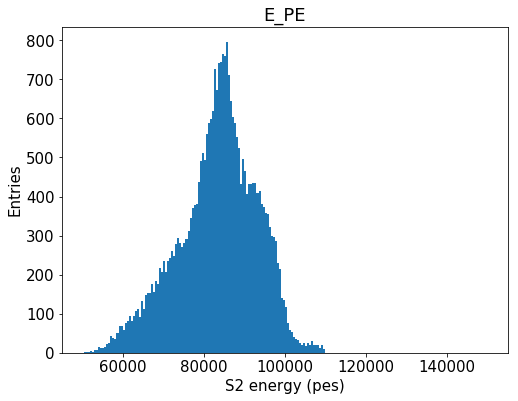

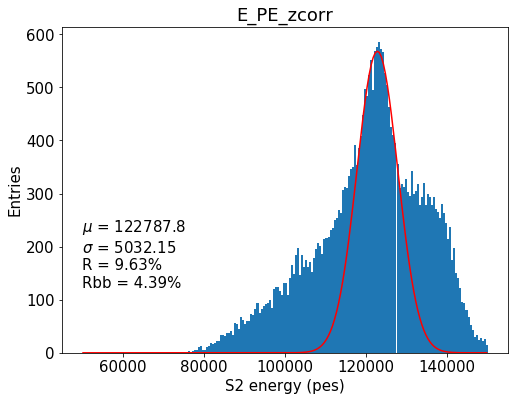

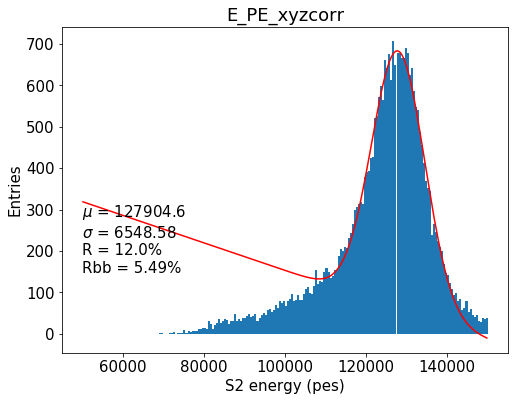

In [20]:
PErange =  5e4, 15e4
Erange  = 10e4, 15e4
E       = np.array(PE.S2e.values)

hist(E, 200, PErange)
labels("S2 energy (pes)", "Entries")
save("E_PE")


E *= zcorr(PE.Z)
y, x, _ = \
hist(E, 200, PErange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])# + fitf.polynom(x, *args[3:])
seed = 1e6, 125e3, 1e3#, 1e3, 1e-2
f    = fitf.fit(fun, x, y, seed, fit_range=(119e3, 128e3))

plt.plot(x, f.fn(x), fitOpt)
plt.text(PErange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
labels("S2 energy (pes)", "Entries")
save("E_PE_zcorr")



E *= xycorr(PE.X.values, PE.Y.values)

y, x, _ = \
hist(E, 200, PErange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.polynom(x, *args[3:])
seed = 1e6, 125e3, 1e3, 1e3, -1e-3
f    = fitf.fit(fun, x, y, seed, fit_range=(105e3, 140e3))

plt.plot(x, f.fn(x), fitOpt)
plt.text(PErange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
labels("S2 energy (pes)", "Entries")
save("E_PE_xyzcorr")

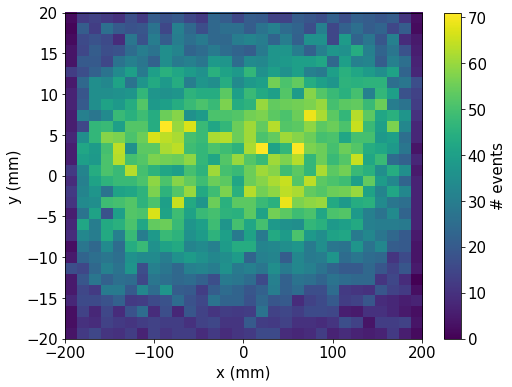

In [45]:
hist2d(PE.X.values, PE.Y.values, 30, ((-200, 200), (-20, 20)))
labels("x (mm)", "y (mm)")
plt.colorbar().set_label("# events")

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


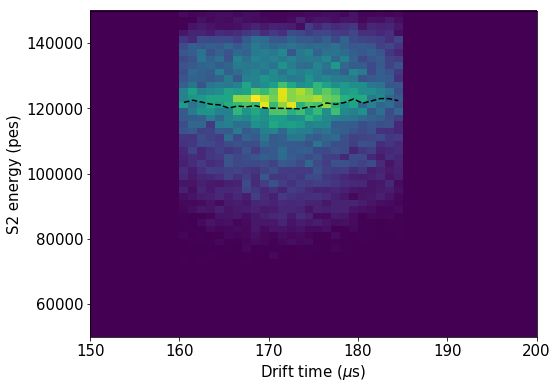

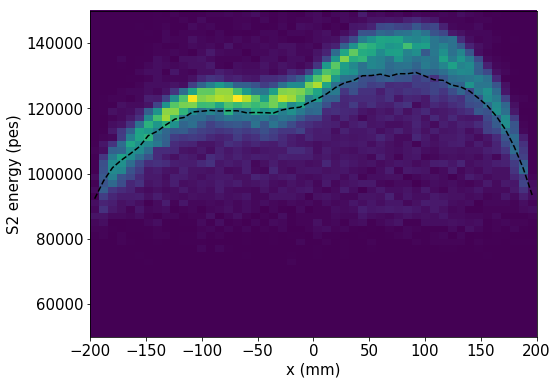

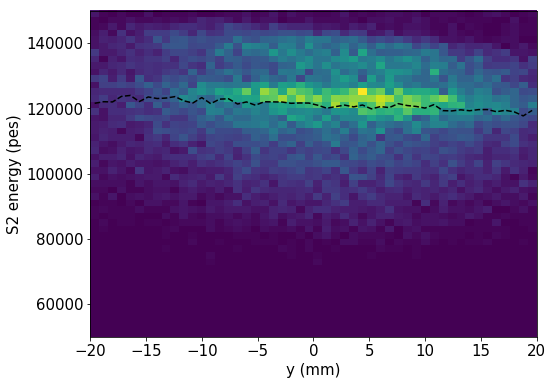

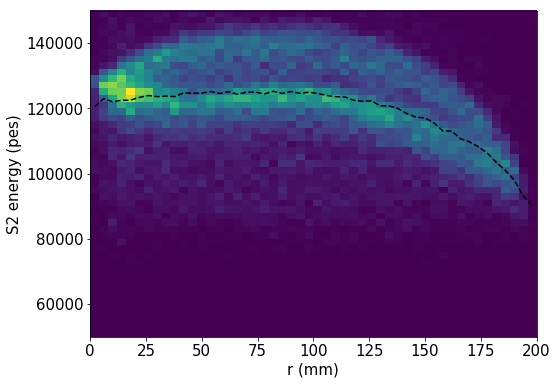

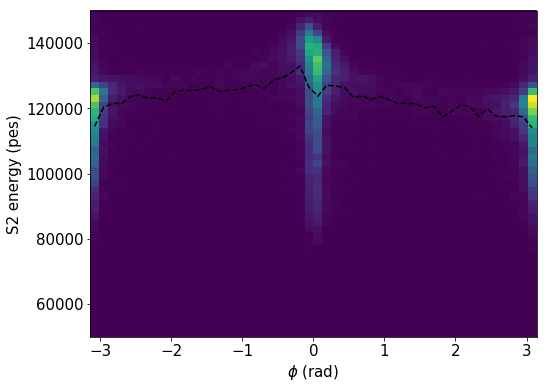

In [21]:
xrange = -200,  200
yrange = - 20,   20
rrange =    0,  200
prange = - pi,   pi
zrange =  150,  200
Erange =  5e4, 15e4
E      = np.array(PE.S2e.values) * zcorr(PE.Z.values)

hist2d(PE.Z, E, 50, (zrange, Erange))
x, y, _ = fitf.profileX(PE.Z.values, E, 50, zrange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

hist2d(PE.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PE.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
labels("x (mm)", "S2 energy (pes)")

hist2d(PE.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PE.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PE.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PE.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PE.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PE.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")

In [22]:
_x     = np.array([ -200,  -150,  -100,   -50,     0,    50,   100,   125,   160,   200])
_emin  = np.array([ 85e3, 100e3, 115e3, 112e3, 117e3, 125e3, 125e3, 118e3, 110e3,  88e3])
_emax  = np.array([105e3, 120e3, 130e3, 128e3, 132e3, 147e3, 147e3, 145e3, 133e3, 112e3])

_eminfid = scp.interpolate.interp1d(_x, _emin, fill_value="extrapolate")
_emaxfid = scp.interpolate.interp1d(_x, _emax, fill_value="extrapolate")

PEfid = PE[coref.in_range(np.array(PE.S2e.values) * zcorr(PE.Z.values), _eminfid(PE.X), _emaxfid(PE.X))]

/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


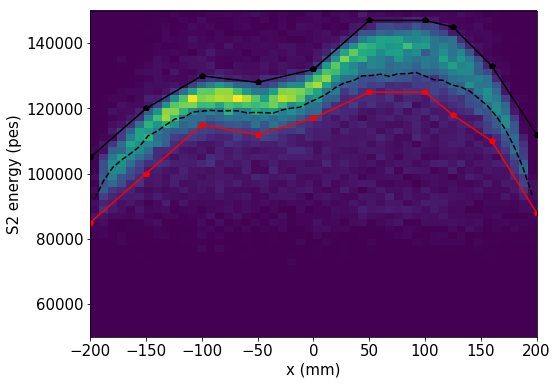

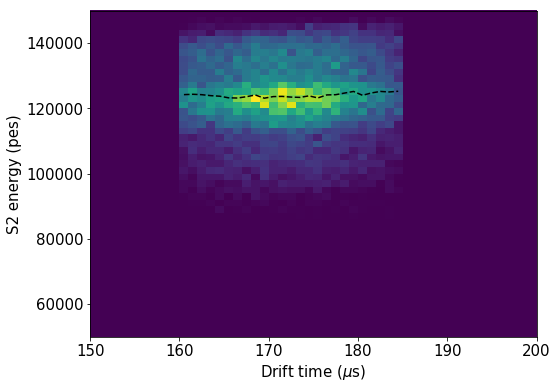

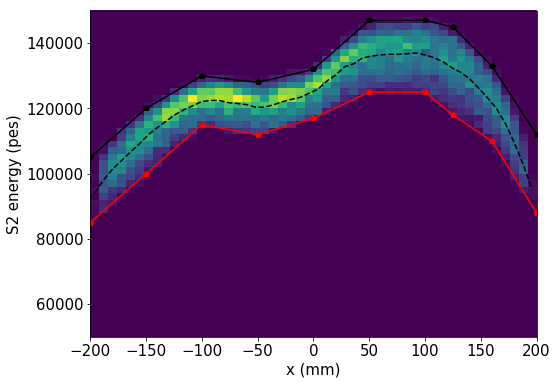

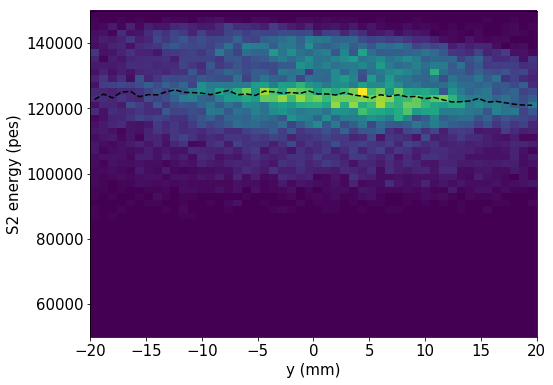

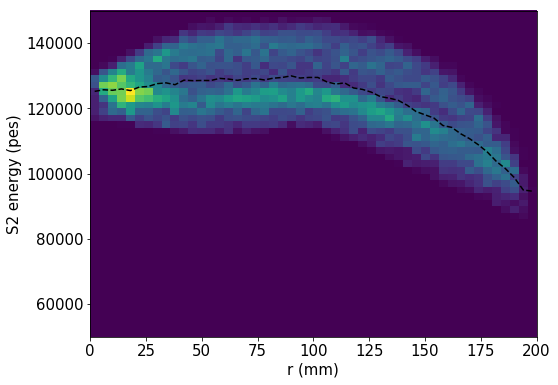

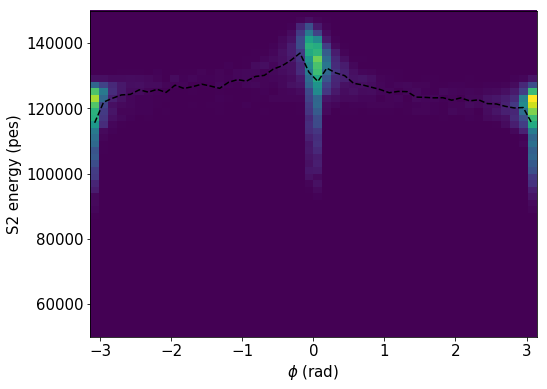

In [23]:
xrange = -200,  200
yrange = - 20,   20
rrange =    0,  200
prange = - pi,   pi
zrange =  150,  200
Erange =  5e4, 15e4
E      = np.array(PE.S2e.values) * zcorr(PE.Z.values)

hist2d(PE.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PE.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")
labels("x (mm)", "S2 energy (pes)")

E     = np.array(PEfid.S2e.values) * zcorr(PEfid.Z.values)

hist2d(PEfid.Z, E, 50, (zrange, Erange))
x, y, _ = fitf.profileX(PEfid.Z.values, E, 50, zrange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

hist2d(PEfid.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PEfid.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
plt.plot(_x, _emin, "pr-", _x, _emax, "pk-")
labels("x (mm)", "S2 energy (pes)")

hist2d(PEfid.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PEfid.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PEfid.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PEfid.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PEfid.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PEfid.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")

125000.0


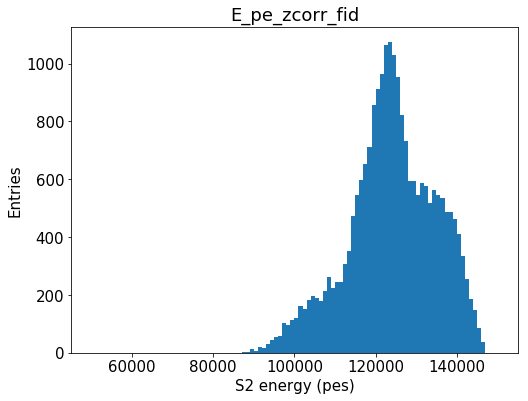

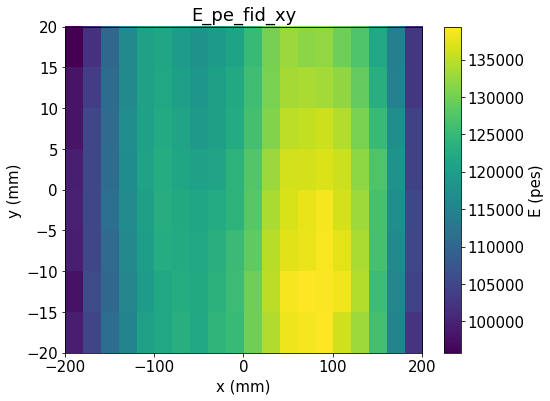

In [24]:
Erange = PErange
E = PEfid.S2e * zcorr(PEfid.Z)

hist(E, 100, Erange)
labels("S2 energy (pes)", "Entries")
save("E_pe_zcorr_fid")

pf, _, cb = profile_and_scatter(PEfid.X, PEfid.Y, E, (20, 8), xrange=xrange, yrange=yrange)
cb.set_label("E (pes)")
labels("x (mm)", "y (mm)")
save("E_pe_fid_xy")
xycorrPE = get_xycorr(*pf[:-1], 125e3)

[  7.99372680e+06   1.26949224e+05   3.08588205e+03   3.37959983e+06
   1.20256107e+05   3.35336518e+03] 2.33369681427


/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/envs/IC3.5/lib/python3.5/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


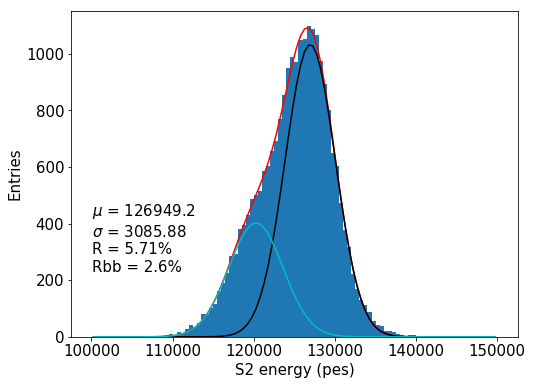

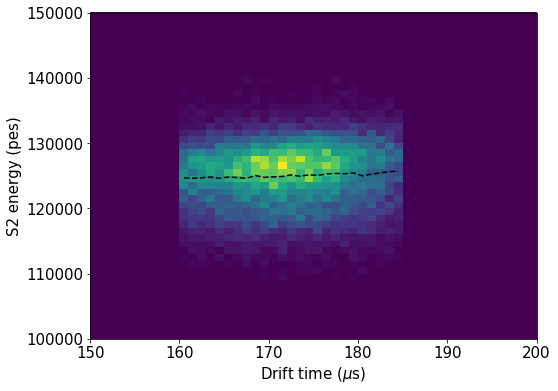

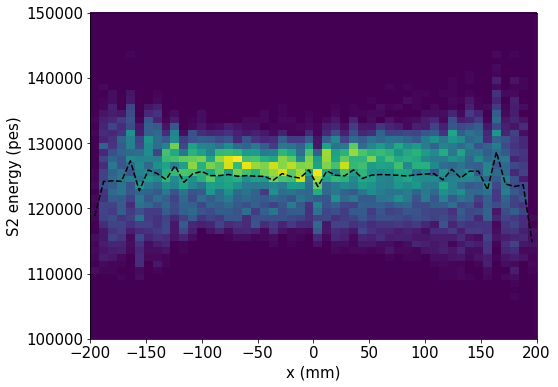

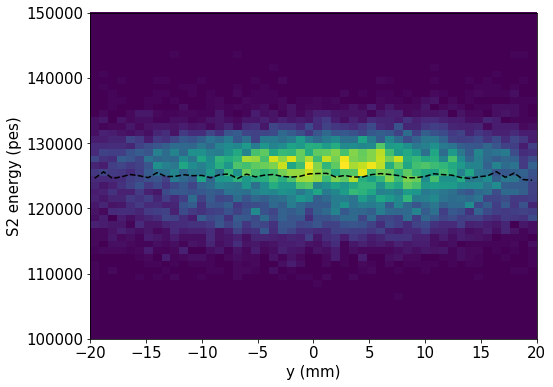

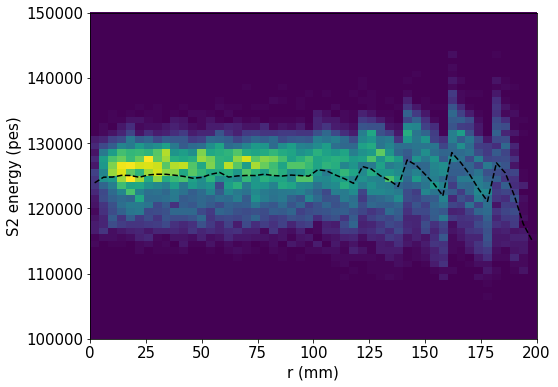

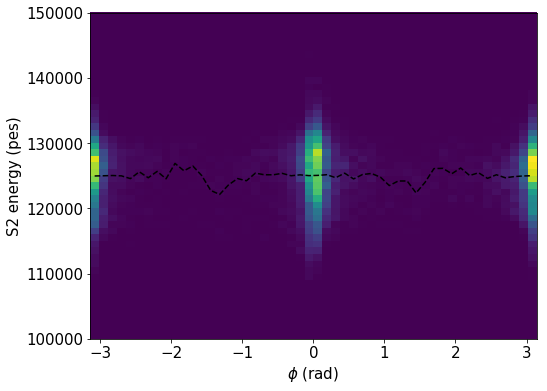

In [25]:
xrange = -200,  200
yrange = - 20,   20
rrange =    0,  200
prange = - pi,   pi
zrange =  150,  200
Erange = 10e4, 15e4
E      = np.array(PEfid.S2e.values) * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values)

y, x, _ = \
hist(E, 100, Erange)
x = x[:-1] + np.diff(x) * 0.5
labels("S2 energy (pes)", "Entries")

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e7, 127e3, 2e3, 1e6, 120e3, 1e3
low  = 1e5, 125e3, 1e3, 1e3, 115e3, 1e3
upp  = 1e9, 130e3, 1e4, 1e9, 125e3, 1e4
f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(110e3, 140e3))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
print(f.values, f.chi2)

hist2d(PEfid.Z, E, 50, (zrange, Erange))
x, y, _ = fitf.profileX(PEfid.Z.values, E, 50, zrange)
plt.plot(x, y, profOpt)
labels("Drift time ($\mu$s)", "S2 energy (pes)")

hist2d(PEfid.X, E, 50, (xrange, Erange))
x, y, _ = fitf.profileX(PEfid.X.values, E, 50, xrange)
plt.plot(x, y, profOpt)
labels("x (mm)", "S2 energy (pes)")

hist2d(PEfid.Y, E, 50, (yrange, Erange))
x, y, _ = fitf.profileX(PEfid.Y.values, E, 50, yrange)
plt.plot(x, y, profOpt)
labels("y (mm)", "S2 energy (pes)")

hist2d(PEfid.R, E, 50, (rrange, Erange))
x, y, _ = fitf.profileX(PEfid.R.values, E, 50, rrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 energy (pes)")

hist2d(PEfid.Phi, E, 50, (prange, Erange))
x, y, _ = fitf.profileX(PEfid.Phi.values, E, 50, prange)
plt.plot(x, y, profOpt)
labels("$\phi$ (rad)", "S2 energy (pes)")

129025.776211


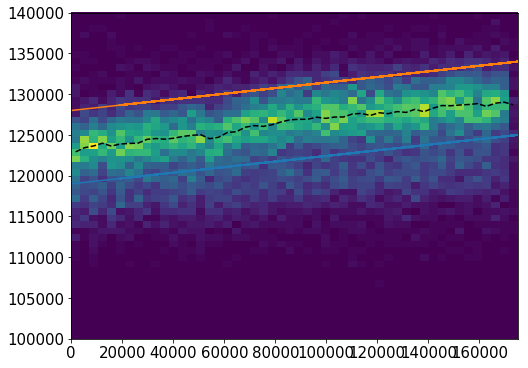

In [26]:
trange = 0, 175e3
Erange = 100e3, 140e3

t0 = np.min(PEfid.time.values)
T  = PEfid.time.values - t0
E  = PEfid.S2e.values * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values)

lowE = 119e3 + 6/175*T
uppE = 128e3 + 6/175*T
sel  = coref.in_range(E, lowE, uppE)


hist2d(T, E, 50, range=(trange, Erange))
plt.plot(T, lowE,
         T, uppE)
x, y, _ = fitf.profileX(T[sel], E[sel], 50, trange)
plt.plot(x, y, profOpt)

tcorr = get_tcorr(x, y, t0)

[  6.88375984e+06   1.29145591e+05   2.60606423e+03   2.08812711e+06
   1.21836852e+05   2.57784419e+03] 5.4147808155


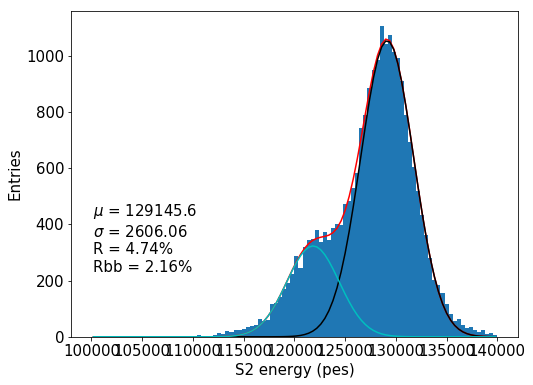

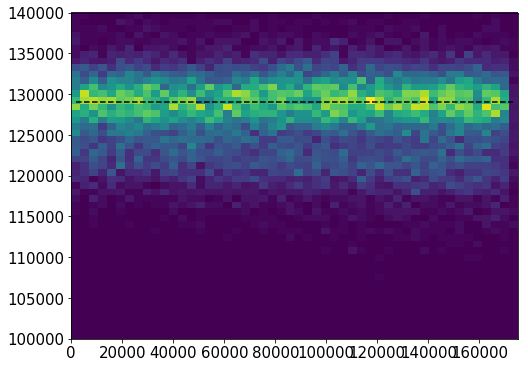

In [27]:
trange = 0, 175e3
Erange = 100e3, 140e3
T      = PEfid.time.values - np.min(PEfid.time.values)
E      = PEfid.S2e.values * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values) * tcorr(PEfid.time.values)

y, x, _ = \
hist(E, 100, Erange)
x = x[:-1] + np.diff(x) * 0.5
labels("S2 energy (pes)", "Entries")

fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
seed = 1e7, 127e3, 2e3, 1e6, 120e3, 1e3
low  = 1e5, 125e3, 1e3, 1e3, 115e3, 1e3
upp  = 1e9, 130e3, 1e4, 1e9, 125e3, 1e4
f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(110e3, 140e3))
plt.plot(x, f.fn(x), fitOpt)
plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
plt.text(Erange[0]+100, plt.ylim()[1]/5, gausstext(f.values[:3], 511))
print(f.values, f.chi2)

hist2d(T, E, 50, range=(trange, Erange))
x, y, _ = fitf.profileX(T[sel], E[sel], 50, trange)
plt.plot(x, y, profOpt)


[ 985525.7616441   130250.13882035    3537.67834673  820331.7540513
  122713.39847641    4350.13602559] 1.06719145195
[ 2138307.13875327   129412.58927358     2739.93509588   613585.97595319
   121730.23585269     2532.67422173] 1.31846007318


/Users/Gonzalo/github/IC/invisible_cities/core/fit_functions.py:102: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum(np.ma.masked_invalid((fitx - y)**2/y))


[  2.30630366e+06   1.28923689e+05   2.04994305e+03   5.34166546e+05
   1.21812398e+05   1.82926769e+03] 1.04266520289
[  2.18553293e+06   1.28706223e+05   2.16375224e+03   5.03582008e+05
   1.21473500e+05   1.84311155e+03] 1.16363760477
[  2.37430751e+06   1.28639634e+05   2.84352826e+03   4.30199631e+05
   1.21192149e+05   2.19116326e+03] 0.806468570694
[ 2043152.65823605   129485.99941037     2276.20517859   843518.45475262
   122737.41307465     2859.03500856] 1.57712471194
[ 1625995.05921029   129830.01662875     2046.11054212  1077216.88917212
   124129.72639503     3576.04308402] 1.52336309116
[ 1572644.27405004   130200.52993788     2823.56546524  1079455.44707999
   123801.09590738     4444.80010917] 1.1450765974
[ 1549736.2960105    127476.52348258     5591.73928971    70714.02416097
   117080.33502995     1702.45542416] 1.32421987011


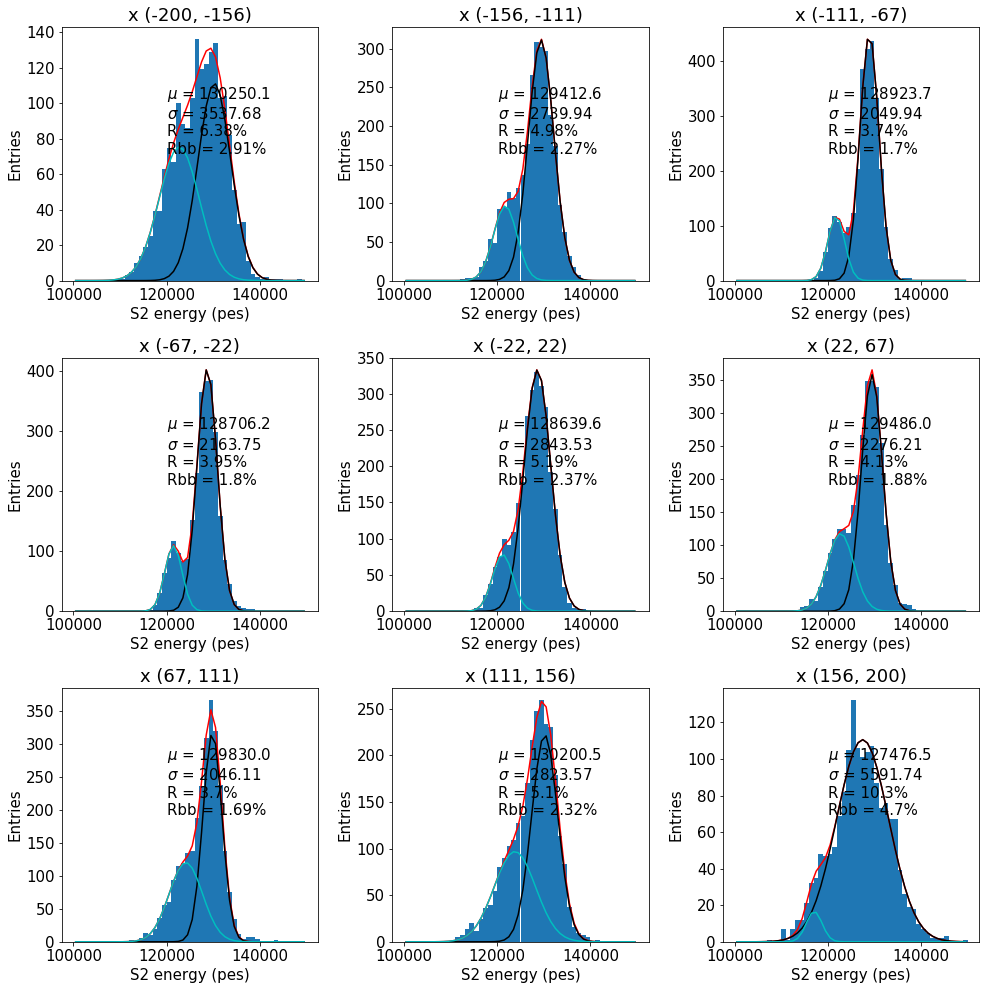

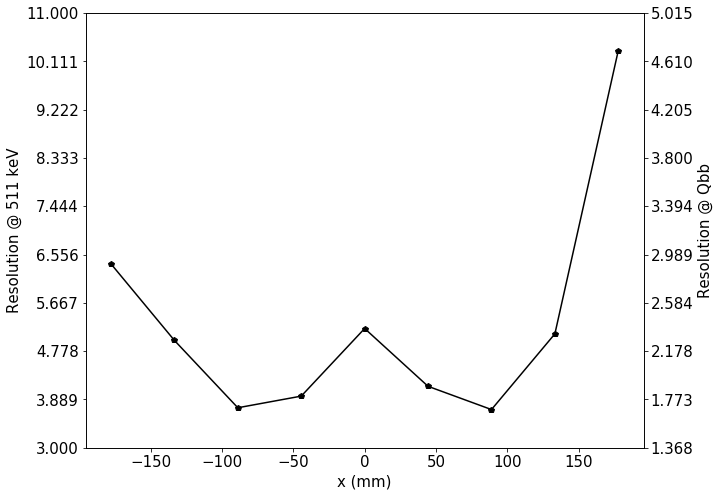

In [46]:
xlim = np.linspace(-200, 200, 10, endpoint=True)

E = PEfid.S2e.values * zcorr(PEfid.Z.values) * xycorrPE(PEfid.X.values, PEfid.Y.values) * tcorr(PEfid.time.values)

R   = []
Rbb = []
plt.figure().set_size_inches(14, 14)
for i in range(9):
    EX = E[coref.in_range(PEfid.X.values, xlim[i], xlim[i+1])]

    plt.subplot(3, 3, i+1)
    y, x, _ = \
    plt.hist(EX, 50, (100e3, 150e3))
    x = x[:-1] + np.diff(x) * 0.5
    labels("S2 energy (pes)", "Entries")

    fun  = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:])
    seed = 1e7, 127e3, 2e3, 1e6, 123e3, 2e3
    low  = 1e5, 125e3, 1e3, 1e4, 115e3, 1e3
    upp  = 1e9, 133e3, 1e4, 1e9, 125e3, 5e3
    f    = fitf.fit(fun, x, y, seed, bounds=(low, upp), fit_range=(110e3, 140e3))
    plt.plot(x, f.fn(x), fitOpt)
    plt.plot(x, fitf.gauss(x, *f.values[:3]), XR1Opt)
    plt.plot(x, fitf.gauss(x, *f.values[3:]), XR2Opt)
    plt.text(Erange[0]+100, plt.ylim()[1]/2, gausstext(f.values[:3], 511))
    plt.title("x ({:.0f}, {:.0f})".format(xlim[i], xlim[i+1]))
    print(f.values, f.chi2)

    res, resbb = reso(f.values[:3], 511)
    R  .append(res)
    Rbb.append(resbb)
plt.tight_layout()

xlim = xlim[:-1] + np.diff(xlim) * 0.5
plt.figure(figsize=(10,8))
plt.plot(xlim, R  , "pk-")
plt.ylim(3, 11)
plt.yticks(np.linspace(3, 11, 10))
labels("x (mm)", "Resolution @ 511 keV")

ax2 = plt.gca().twinx()
#ax2.plot(xlim, R, "pk-")
ax2.set_ylim(3 * (511/2458)**0.5, 11 * (511/2458)**0.5)
ax2.set_yticks(np.linspace(3, 11, 10) * (511/2458)**0.5)
ax2.set_ylabel("Resolution @ Qbb");

# Corrections applied to a different run

In [29]:
full_3740 = dstf.load_dst("/Users/Gonzalo/github/NEXTdata/Na22/dst_3740.root.h5", "DST", "Events")
full_3740.head()

,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.492688e+09,0,1,175.0,18.115389,98.167735,200125.0,12.968500,7523.225586,...,432562.5,29,232.4375,232.4375,-121.853423,-149.118532,192.573605,-2.255912,12.261129,11.101232
1,2,1.492688e+09,0,2,175.0,26.000633,132.471552,200100.0,18.705000,6250.221191,...,369537.5,18,169.4375,169.4375,107.439785,3.741262,107.504905,0.034808,8.879782,8.889234
2,2,1.492688e+09,1,2,175.0,26.000633,132.471552,200100.0,11.890063,8061.866699,...,403062.5,16,202.9625,202.9625,84.813722,28.916453,89.607637,0.328582,9.371138,8.689273
3,165,1.492688e+09,0,1,175.0,25.544876,132.948239,200125.0,22.098500,8880.192383,...,378162.5,35,178.0375,178.0375,190.489065,-5.902461,190.580489,-0.030976,11.757106,12.183691
4,166,1.492688e+09,0,4,150.0,20.747416,100.323810,200150.0,5.925969,6598.466797,...,273537.5,12,73.3875,73.3875,-151.827148,103.425270,183.707021,2.543593,8.439454,6.771775


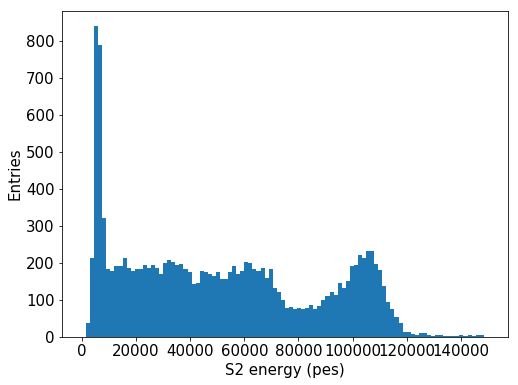

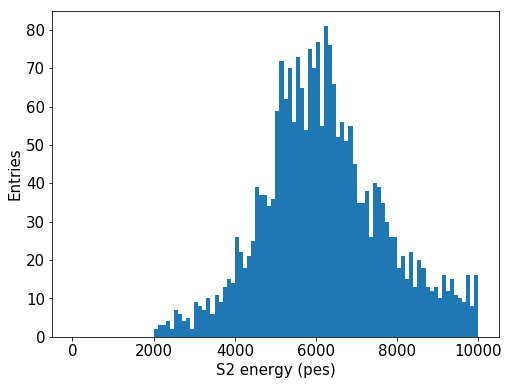

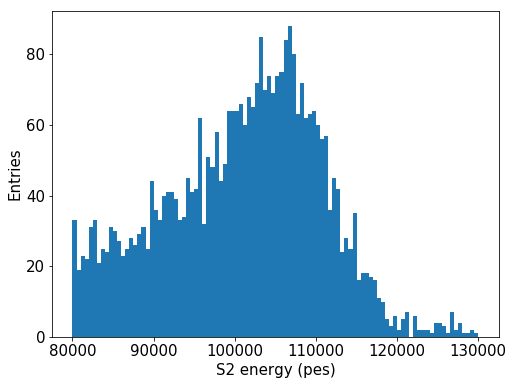

In [30]:
Erange  =   0, 15e4
XRrange =   0,  1e4
PErange = 8e4, 13e4

hist(full_3740.S2e, 100, Erange)
labels("S2 energy (pes)", "Entries")

hist(full_3740.S2e, 100, XRrange)
labels("S2 energy (pes)", "Entries")

hist(full_3740.S2e, 100, PErange)
labels("S2 energy (pes)", "Entries")

In [31]:
XR_3740 = full_3740
XR_3740 = XR_3740[coref.in_range(XR_3740.Z  ,   0, 160)]
XR_3740 = XR_3740[coref.in_range(XR_3740.S2e, 4e3, 9e3)]

_LT = 520
zcorr_3740 = lambda z: np.exp(z/_LT)

[ 104669.42260467    8411.2515731      646.08859361] 0.989787454687
[ 104360.81819655    8672.94755537     536.69803439] 0.859640718017


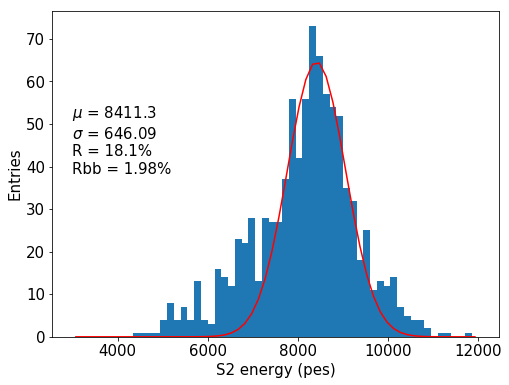

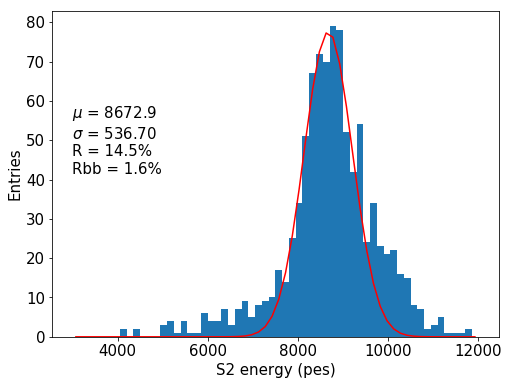

In [32]:
XRrange = 3e3, 12e3

E = XR_3740.S2e.values * zcorr_3740(XR_3740.Z.values)
y, x, _ = \
hist(E, 60, XRrange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])
seed = 1e4, 8e3, 4e2
f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 9100))
plt.plot(x, f.fn(x), fitOpt)
plt.text(XRrange[0], plt.ylim()[1]/2, gausstext(f.values[:3], 29.6))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2)

E *= xycorr(XR_3740.X.values, XR_3740.Y.values)
y, x, _ = \
hist(E, 60, XRrange)
x = x[:-1] + np.diff(x) * 0.5

fun  = lambda x, *args: fitf.gauss(x, *args[:3])
seed = 1e4, 8e3, 4e2
f    = fitf.fit(fun, x, y, seed, fit_range=(7500, 9100))
plt.plot(x, f.fn(x), fitOpt)
plt.text(XRrange[0], plt.ylim()[1]/2, gausstext(f.values[:3], 29.6))
labels("S2 energy (pes)", "Entries")

print(f.values, f.chi2)


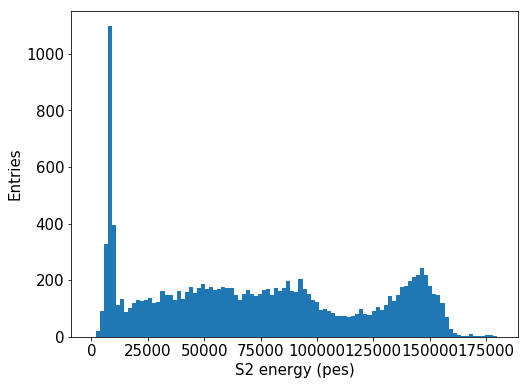

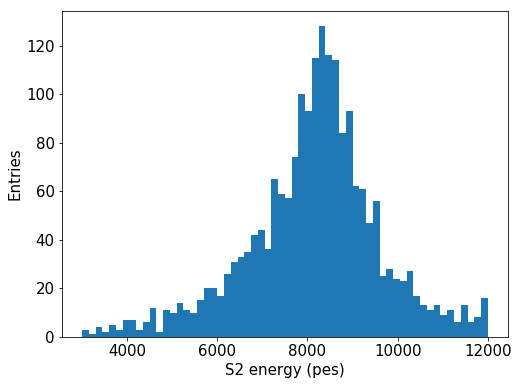

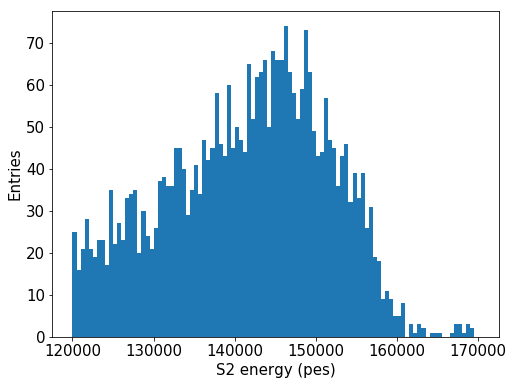

In [33]:
Erange  =    0, 18e4
XRrange =  3e3, 12e3
PErange = 12e4, 17e4

E = full_3740.S2e.values * zcorr_3740(full_3740.Z.values)
hist(E, 100, Erange)
labels("S2 energy (pes)", "Entries")

hist(E, 60, XRrange)
labels("S2 energy (pes)", "Entries")

hist(E, 100, PErange)
labels("S2 energy (pes)", "Entries")

In [34]:
PE_3740 = full_3740
PE_3740 = PE_3740[coref.in_range(PE_3740.S1e,  100,   150)]
PE_3740 = PE_3740[coref.in_range(PE_3740.S2e, 90e3, 120e3)]
PE_3740 = PE_3740[coref.in_range(PE_3740.Z  ,  160,   185)]
PE_3740 = PE_3740[coref.in_range(PE_3740.Y  ,  -20,    20)]
PE_3740 = PE_3740[PE_3740.nS2==1]

len(PE)

29499

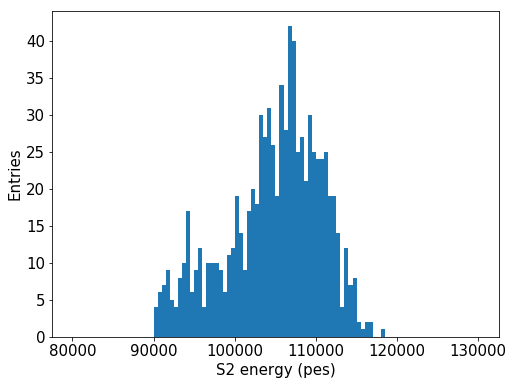

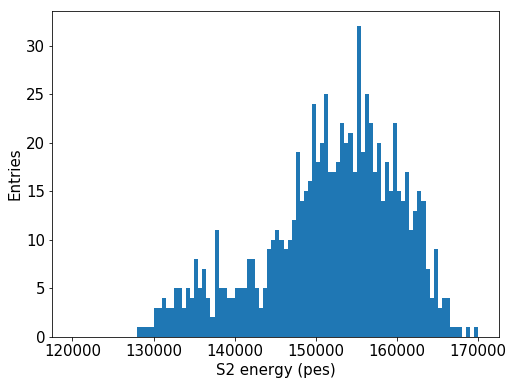

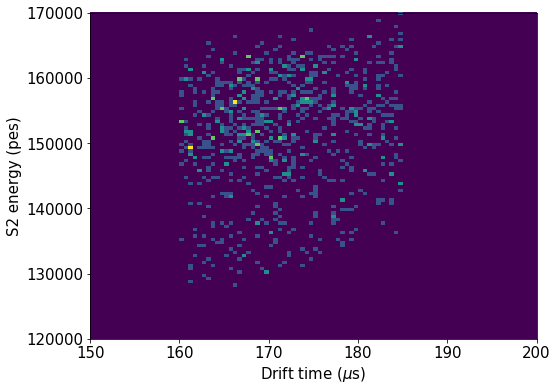

In [35]:
PErange = 8e4, 13e4
hist(PE_3740.S2e.values, 100, PErange)
labels("S2 energy (pes)", "Entries")

PErange = 12e4, 17e4
hist(PE_3740.S2e.values * zcorr(PE_3740.Z.values), 100, PErange)
labels("S2 energy (pes)", "Entries")


zrange = 150, 200
hist2d(PE_3740.Z.values, PE_3740.S2e.values * zcorr(PE_3740.Z.values), 100, (zrange, PErange))
labels("Drift time ($\mu$s)", "S2 energy (pes)")


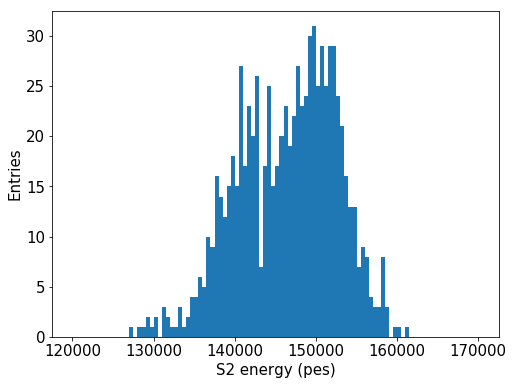

In [36]:
Erange = 12e4, 17e4

E = PE_3740.S2e.values * zcorr_3740(PE_3740.Z.values) * xycorrPE(PE_3740.X.values, PE_3740.Y.values)
hist(E, 100, Erange)
labels("S2 energy (pes)", "Entries")